In [1]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
from sklearn import preprocessing
#import pydot

from graphviz import Source


%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

## План занятия.
- решающие деревья, общая парадигма
- критерии разбиения датасета
- специальные алгоритмы построения деревьев
- практические примеры


# Деревья решений

Формально, дерево решений - это связный ациклический граф. В нем можно выделить 3 типа вершин:
1. Корневая вершина (root node) -  откуда все начинается
2. Внутренние вершины (intermediate nodes)
3. Листья (leafs) - самые глубокие вершины дерева, в которых содержится "ответ"

Во внутренней или коневой вершине признак проверяется на некий логический критерий, по результатам которого мы движемся все глубже

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

In [4]:
#conda install graphviz

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /Users/olga/opt/anaconda3

  added / updated specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.4.13  |       hecd8cb5_1         114 KB
    cairo-1.14.12              |       hc4e6be7_4         860 KB
    cffi-1.14.0                |   py38hb5b8e2f_0         216 KB
    conda-4.10.1               |   py38hecd8cb5_1         2.9 MB
    fontconfig-2.13.1          |       ha9ee91d_0         211 KB
    fribidi-1.0.10             |       haf1e3a3_0          63 KB
    glib-2.63.1                |       hd977a24_0         2.6 MB
    graphite2-1.3.14           |       h38d11af_0          80 KB
   

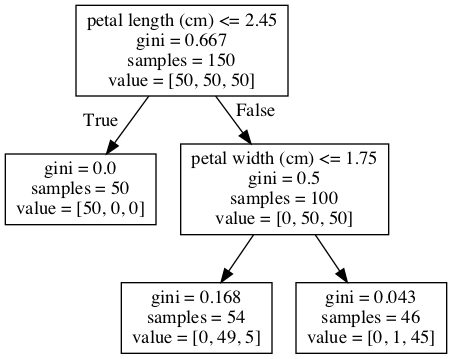

In [3]:
graph = Source(sklearn.tree.export_graphviz(tree_clf, out_file=None, feature_names=iris.feature_names[2:]))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

| Outlook | Temperature | Humidity | Wind | Play |
| --- | --- | --- | --- | --- |
|Sunny | 85 | 85 | false | no |
|Sunny | 80 | 90 | true | no |
|Overcast | 83 | 86 | false | yes |
|Rainy | 70 | 96 | false | yes |
|Rainy | 68 | 80 | false | yes |
|Rainy | 65 | 70 | true | no |
|Overcast | 64 | 65 | true | yes |
|Sunny | 72 | 95 | false | no |
|Sunny | 69 | 70 | false | yes |
|Rainy | 75 | 80 | false | yes |
|Sunny | 75 | 70 | true | yes |
|Overcast | 72 | 90 | true | yes |
|Overcast | 81 | 75 | false | yes |
|Rainy | 71 | 91 | true | no |

<img src="pics/golf.png">

In [10]:
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO


golf = StringIO("""Outlook,Temperature,Humidity,Wind,Play
Sunny,85,85,false,no
Sunny,80,90,true,no
Overcast,83,86,false,yes
Rainy,70,96,false,yes
Rainy,68,80,false,yes
Rainy,65,70,true,no
Overcast,64,65,true,yes
Sunny,72,95,false,no
Sunny,69,70,false,yes
Rainy,75,80,false,yes
Sunny,75,70,true,yes
Overcast,72,90,true,yes
Overcast,81,75,false,yes
Rainy,71,91,true,no
""")

df = pd.read_csv(golf, sep=',')

In [4]:
df

,Outlook,Temperature,Humidity,Wind,Play
0,Sunny,85,85,False,no
1,Sunny,80,90,True,no
2,Overcast,83,86,False,yes
3,Rainy,70,96,False,yes
4,Rainy,68,80,False,yes
5,Rainy,65,70,True,no
6,Overcast,64,65,True,yes
7,Sunny,72,95,False,no
8,Sunny,69,70,False,yes
9,Rainy,75,80,False,yes


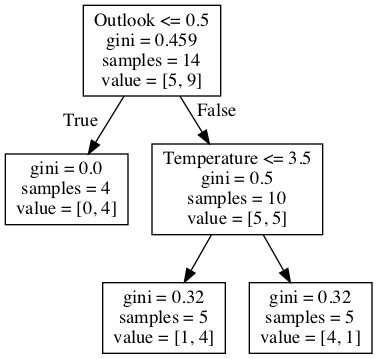

In [13]:
graph = Source(sklearn.tree.export_graphviz(tree_clf, out_file=None, feature_names=['Outlook', 'Wind', 'Temperature', 'Humidity']))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

In [18]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

d = defaultdict(LabelEncoder)
X = np.c_[
    df[['Outlook', 'Wind']].apply(lambda x: d[x.name].fit_transform(x)).values,
    df[['Temperature', 'Humidity']].values
]
y = df[['Play']].values
print(X)


[[ 2  0 85 85]
 [ 2  1 80 90]
 [ 0  0 83 86]
 [ 1  0 70 96]
 [ 1  0 68 80]
 [ 1  1 65 70]
 [ 0  1 64 65]
 [ 2  0 72 95]
 [ 2  0 69 70]
 [ 1  0 75 80]
 [ 2  1 75 70]
 [ 0  1 72 90]
 [ 0  0 81 75]
 [ 1  1 71 91]]


In [19]:
o = d['Outlook']

In [20]:
o.classes_

array(['Overcast', 'Rainy', 'Sunny'], dtype=object)

In [21]:
tree_clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)

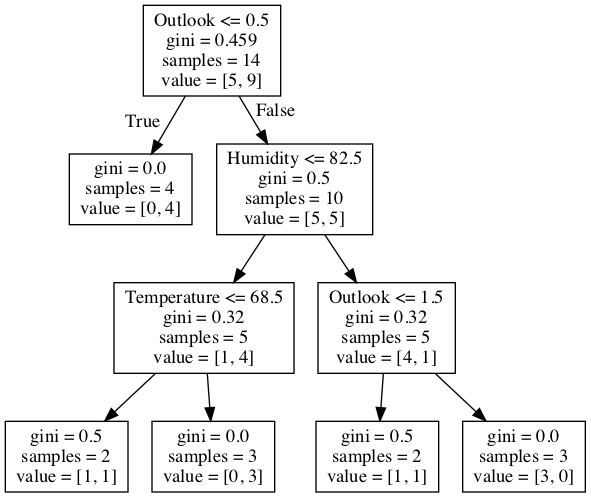

In [22]:
graph = Source(sklearn.tree.export_graphviz(tree_clf, out_file=None, feature_names=['Outlook', 'Wind', 'Temperature', 'Humidity']))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

# CART - Classification And Regression Trees
1. Как происходит разделение?
2. На сколько детей разделять каждый узел?
3. Какой критерий листа выбрать?
4. Как выбрать класс каждого листа?
5. Что делать, если часть значений отсутствует?

### Меры неопределенности (impurity measures)

Пусть $p_k$ - это доля класса $C_k$ в узле дерева $S$.

1. Missclassification error  
$$i(N) = 1 - \max_k p(x \in C_k)$$
2. Gini
$$i(N) = 1 - \sum_k p^2(x \in C_k) = \sum_{i \neq j} p(x \in C_i) p(x \in C_j)$$
3. Информационная энтропия
$$i(N) =  -\sum_k p(x \in C_k) \log_2 p(x \in C_k)$$


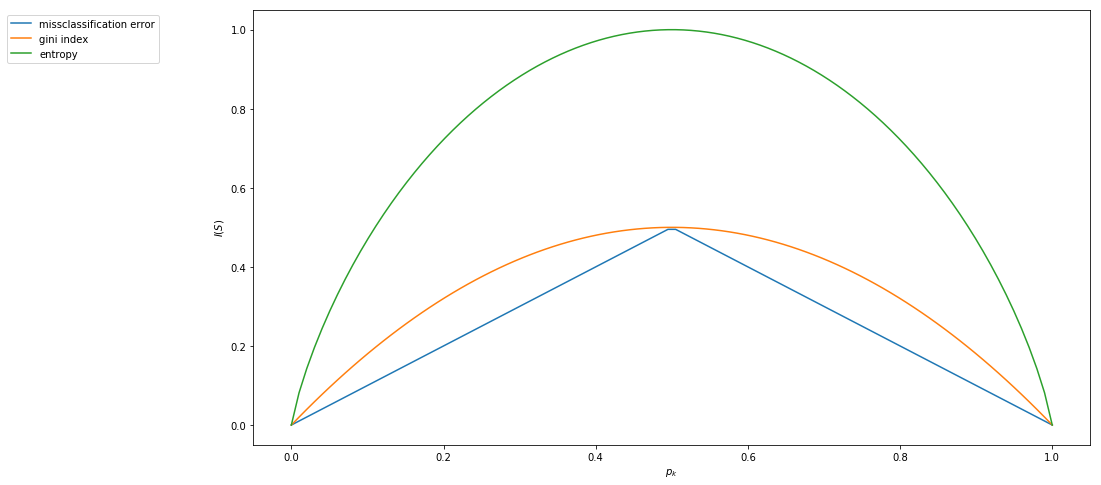

In [65]:
def plot_impurities():
    threshold = 0.000001
    p = np.linspace(0, 1, 100)
    p = np.c_[p, 1-p]

    missclass = 1 - p.max(axis=1)
    plt.plot(p[:,0], missclass, label = 'missclassification error')

    gini = 1 - (p ** 2).sum(axis=1)
    plt.plot(p[:,0], gini, label = 'gini index')

    entropy = - np.nansum((p * np.log2(np.clip(p, threshold, 1 - threshold))), axis=1)
    plt.plot(p[:,0], entropy, label = 'entropy')

    plt.xlabel('$p_k$')
    plt.ylabel('$I(S)$')
    # plt.legend(loc=2, bbox_to_anchor=(0.,0.))
    plt.legend(loc=2, bbox_to_anchor=(-0.3,1))
    
plot_impurities()

<img src="pics/DS1.png">

In [142]:
n = 10

<img src="pics/DS3.png">

In [143]:
ME_1_left = 1 - 5./5
ME_1_left # 0

0.0

In [ ]:
#-2/5*log(2/5) - 3/5*log(3/5)

In [144]:
ME_1_right = 1 - 3 / 5.
ME_1_right # 4/10

0.4

<img src="pics/DS2.png">

In [145]:
ME_2_left = 1 - 7./7
ME_2_left

0.0

In [146]:
ME_2_right = 1 - 3./3
ME_2_right

0.0

In [147]:
ME_all = 1 - 7. / 10
ME_all

0.30000000000000004

### Прирост информации

Выбрать признак и точку отсечения такими, чтобы было максимально уменьшение $impurity$
$$Information Gain = \Delta i(N, N_L, N_R) = i(N) - \frac {N_L}{N} i(N_L) - \frac {N_R}{N} i(N_R)$$

* Стратегия выбора - жадная
* Как определяется порог при вещественных признаках?
* Локальная оптимизация - уменьшение Impurity внутри узла
* Результаты не сильно зависят от выбора самой меры неопределенности




In [148]:
# 1
ME_all - ((5 / n) * ME_1_left + (5 / n) * ME_1_right)

0.10000000000000003

In [154]:
(5 / n) * ME_1_left, (5 / n) * ME_1_right

(0.0, 0.2)

In [149]:
# 2
ME_all - ((7 / n) * ME_2_left + (3 / n) * ME_2_right)

0.30000000000000004

In [156]:
(7 / n) * ME_2_left, (3 / n) * ME_2_right

(0.0, 0.0)

## Рассчет разбиения в выборке

In [165]:
df[['Temperature', 'Play']].sort_values('Temperature')

,Temperature,Play
6,64,yes
5,65,no
4,68,yes
8,69,yes
3,70,yes
13,71,no
7,72,no
11,72,yes
9,75,yes
10,75,yes


## Критерии останова (регуляризация)

* Никогда
* Задать порог по мере неопределенности: $I(S) \leq \theta$
* Задать порог по размеру узла: $|S| \leq n$
* Задать порог на глубину: $Depth(S) = d$
* Задать порог на размер потомков: $|S_L| \leq n_1 \& |S_R| \leq n_2$
* Использовать валидационную выборку
* ...

## Как определяется ответ?

* Классификация
    * Класс с большинством в листе
    * Доли каждого из классов в листе


# Demo
http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

## Важность признаков

В деревьях решений производится автоматический отбор признаков.

Пусть $v(S)$ - это признак, который использовался для ветвления в узле $S$

$$ \text{imp}(A) = \sum\limits_{i: v(S_i) = A} \frac{|S_i|}{|S|} Gain(S_i, A) $$

## Отсутствующие значения

* Удалить объекты из выборки
* Использовать отстутсвие как отдельную категорию
* Вычислять impurity, пропуская отсутствующие значения



**Плюсы:**
 - Порождение четких правил классификации, понятных человеку, например, "если возраст < 25 и интерес к мотоциклам, отказать в кредите"
 - Деревья решений могут легко визуализироваться
 - Относительно быстрые процессы обучения и классификации
 - Малое число параметров модели 
 - Поддержка и числовых, и категориальных признаков
 
**Минусы:**
 - Разделяющая граница, построенная деревом решений, имеет свои ограничения (состоит из гиперкубов), и на практике дерево решений по качеству классификации уступает некоторым другим методам
 - Необходимость отсекать ветви дерева (pruning) или устанавливать минимальное число элементов в листьях дерева или максимальную глубину дерева для борьбы с переобучением. Впрочем, переобучение - проблема всех методов машинного обучения
 - Нестабильность. Небольшие изменения в данных могут существенно изменять построенное дерево решений. С этой проблемой борются с помощью ансамблей деревьев решений (рассмотрим далее)
 - Проблема поиска оптимального дерева решений NP-полна, поэтому на практике используются эвристики типа жадного поиска признака с максимальным приростом информации, которые не гарантируют нахождения глобально оптимального дерева
 - Сложно поддерживаются пропуски в данных. Friedman оценил, что на поддержку пропусков в данных ушло 50% кода CART. 

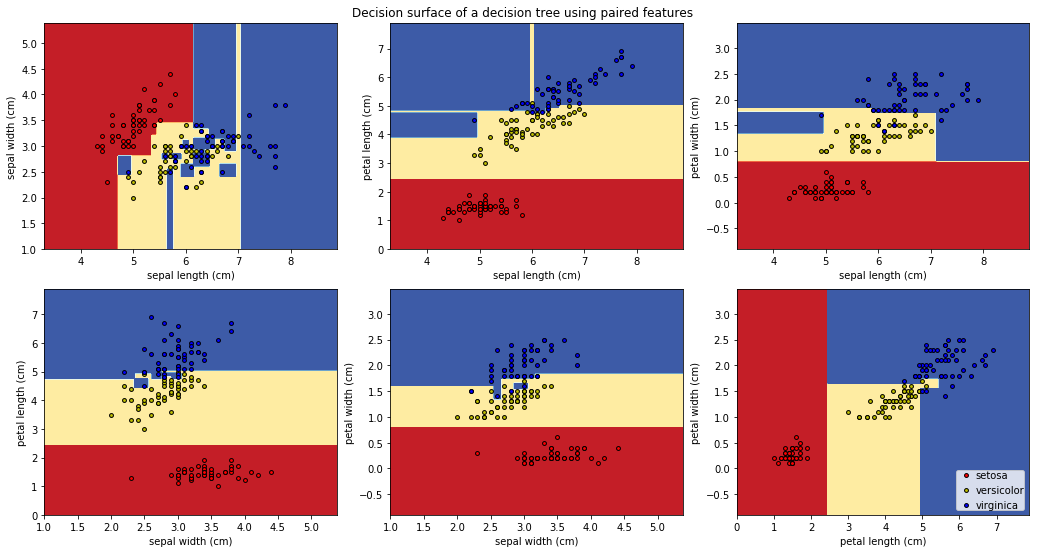

In [167]:
# http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html#sphx-glr-auto-examples-tree-plot-iris-py
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

# Load data
iris = load_iris()

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

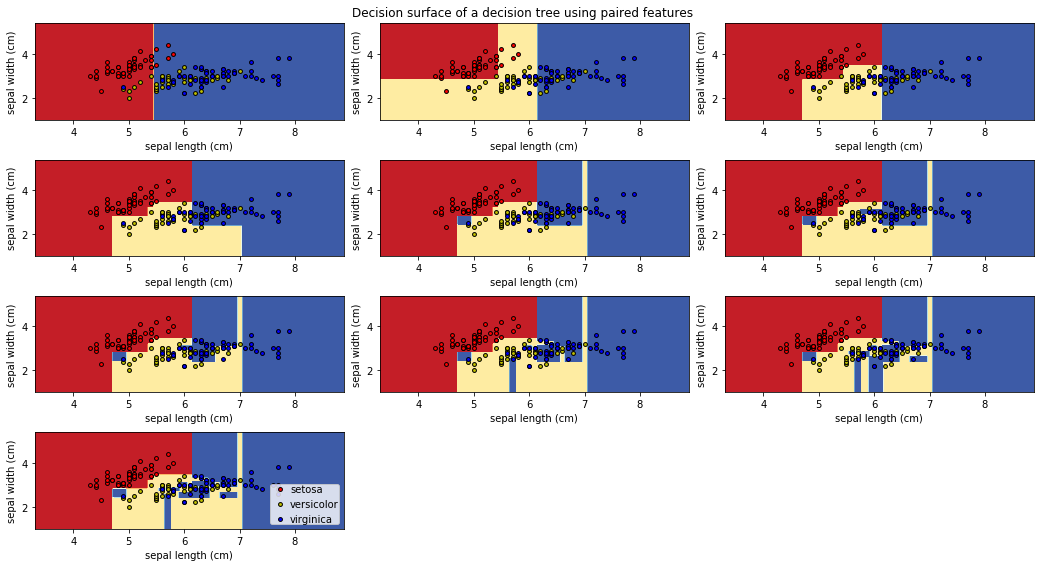

In [171]:
pair = [0, 1]
# We only take the two corresponding features

X = iris.data[:, pair]
y = iris.target

for d in range(10):
    # Train
    clf = DecisionTreeClassifier(max_depth=d+1).fit(X, y)

    # Plot the decision boundary
    plt.subplot(4, 3, d + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

# Материалы
* https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy
* https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3